In [2]:
%load_ext zipline
%load_ext watermark
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

from collections import OrderedDict
import pytz

# необходимые функции zipline
from zipline.api import (order, record, symbol, set_benchmark, order_target_percent, get_open_orders, order_target, 
                        schedule_function, date_rules, time_rules, order_percent, symbols)
# комиссии
from zipline.finance import commission

# выбор календаря по которому происходит торговля
from trading_calendars.always_open import AlwaysOpenCalendar

import zipline

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime, date

# aинансовые данные
from yahoofinancials import YahooFinancials

# отчёт
import pyfolio as pf

# import helper functions 
import qf_helper_functions as qf

import pypfopt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

import pylab

from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import style
from matplotlib import mlab
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.ticker as mtick
%matplotlib inline

plt.style.use('default')
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 200

#векторный формат
%config InlineBackend.figure_format = 'svg'

from tqdm import tqdm

# Прогружаем данные

In [4]:
def download_csv_data(ticker, start_date, end_date, freq, path):
    
    yahoo_financials = YahooFinancials(ticker)

    df = yahoo_financials.get_historical_price_data(start_date, end_date, freq)
    df = pd.DataFrame(df[ticker]['prices']).drop(['date'], axis=1) \
            .rename(columns={'formatted_date':'date'}) \
            .loc[:, ['date','open','high','low','close', 'adjclose', 'volume']] \
            .set_index('date')
    df.index = pd.to_datetime(df.index)
    df['dividend'] = 0
    df['split'] = 1

    # save data to csv for later ingestion
    df.to_csv(path, header=True, index=True)

    # plot the time series
    df.close.plot(title='{} prices --- {}:{}'.format(ticker, start_date, end_date), color='green', fontsize=8);

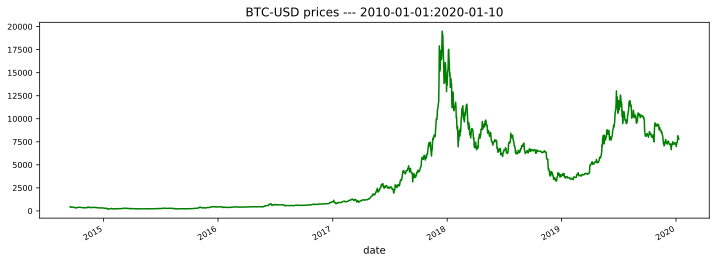

In [7]:
download_csv_data(ticker='BTC-USD', 
                  start_date='2010-01-01', 
                  end_date='2020-01-10', 
                  freq='daily', 
                  path='data/BTC.csv')

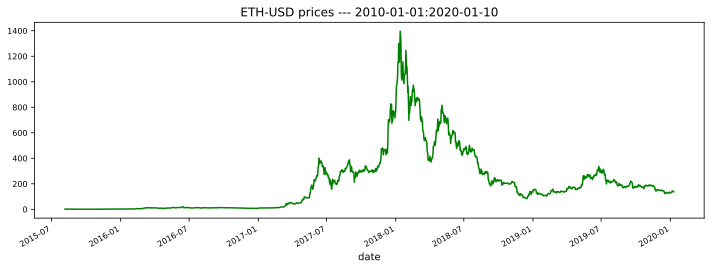

In [8]:
download_csv_data(ticker='ETH-USD', 
                  start_date='2010-01-01', 
                  end_date='2020-01-10', 
                  freq='daily', 
                  path='data/ETH.csv')

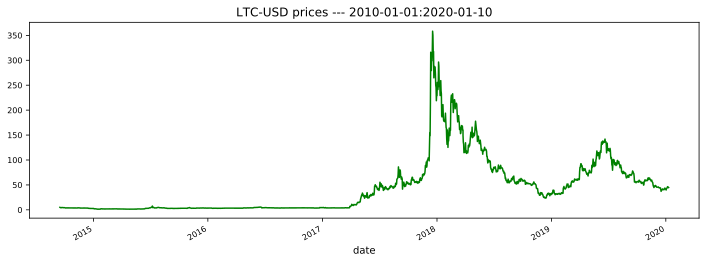

In [9]:
download_csv_data(ticker='LTC-USD', 
                  start_date='2010-01-01', 
                  end_date='2020-01-10', 
                  freq='daily', 
                  path='data/LTC.csv')

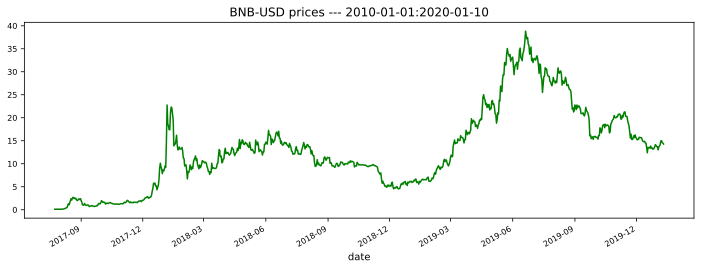

In [10]:
download_csv_data(ticker='BNB-USD', 
                  start_date='2010-01-01', 
                  end_date='2020-01-10', 
                  freq='daily', 
                  path='data/BNB.csv')

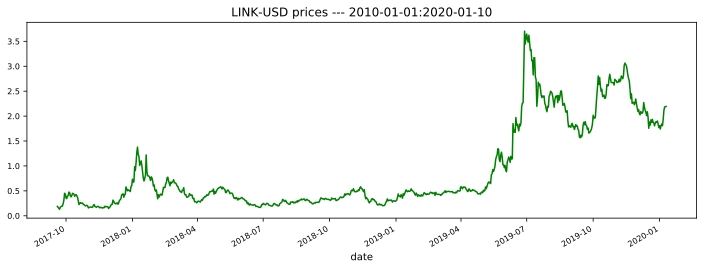

In [12]:
download_csv_data(ticker='LINK-USD', 
                  start_date='2010-01-01', 
                  end_date='2020-01-10', 
                  freq='daily', 
                  path='data/LINK.csv')

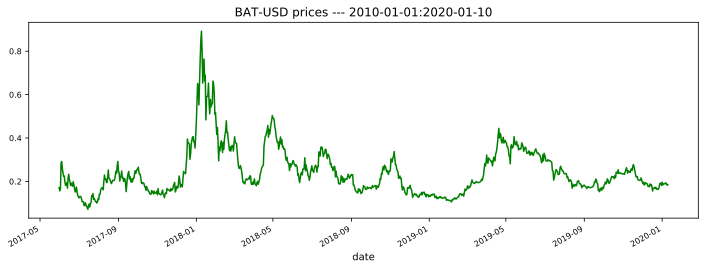

In [13]:
download_csv_data(ticker='BAT-USD', 
                  start_date='2010-01-01', 
                  end_date='2020-01-10', 
                  freq='daily', 
                  path='data/BAT.csv')

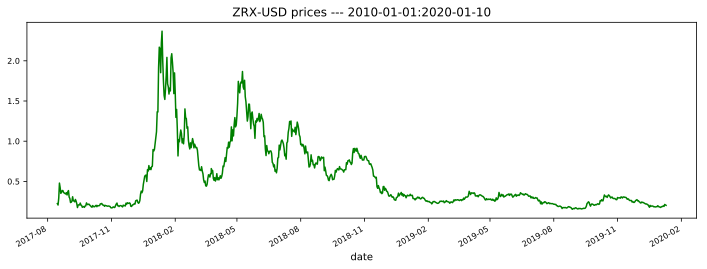

In [14]:
download_csv_data(ticker='ZRX-USD', 
                  start_date='2010-01-01', 
                  end_date='2020-01-10', 
                  freq='daily', 
                  path='data/ZRX.csv')

In [15]:
# Список финансовых инструментов в портфеле
TIKERS = ['BTC', 'ETH', 'LTC', 'BNB', 'LINK', 'BAT', 'ZRX']

# Данные которые будут использоваться в дальнейшем
COLUMNS = ['open', 'close', 'adjclose']

In [16]:
data = OrderedDict()

for tiker in TIKERS:
    data[tiker] = pd.read_csv("data/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    data[tiker] = data[tiker][COLUMNS]
    data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)
    data[tiker]['close'] = data[tiker]['adjclose']
    data[tiker]['open'] = data[tiker]['adjclose']
    del data[tiker]['adjclose']
    print(data[tiker].head())
COLUMNS = ['open', 'close']

                  open       close
date                              
2014-09-16  457.334015  457.334015
2014-09-17  424.440002  424.440002
2014-09-18  394.795990  394.795990
2014-09-19  408.903992  408.903992
2014-09-20  398.821014  398.821014
                open     close
date                          
2015-08-06  2.772120  2.772120
2015-08-07  0.753325  0.753325
2015-08-08  0.701897  0.701897
2015-08-09  0.708448  0.708448
2015-08-10  1.067860  1.067860
               open    close
date                        
2014-09-16  5.05855  5.05855
2014-09-17  4.68523  4.68523
2014-09-18  4.32777  4.32777
2014-09-19  4.28644  4.28644
2014-09-20  4.24592  4.24592
                open     close
date                          
2017-07-24  0.105870  0.105870
2017-07-25  0.105138  0.105138
2017-07-26  0.107737  0.107737
2017-07-27  0.104067  0.104067
2017-07-28  0.107811  0.107811
                open     close
date                          
2017-09-19  0.189165  0.189165
2017-09-20  0.169680  0.1

In [17]:
panel = pd.Panel(data)
panel.minor_axis = COLUMNS
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

<class 'pandas.core.panel.Panel'>
Dimensions: 7 (items) x 1943 (major_axis) x 2 (minor_axis)
Items axis: BTC to ZRX
Major_axis axis: 2014-09-16 00:00:00+00:00 to 2020-01-10 00:00:00+00:00
Minor_axis axis: open to close


# Взаимная корреляция

In [18]:
data_corr = data['BTC']
for tiker in TIKERS:
    data_corr[tiker] = data[tiker]['close']
del data_corr['open']
del data_corr['close']
data_corr.corr()

,BTC,ETH,LTC,BNB,LINK,BAT,ZRX
BTC,1.000000,0.774063,0.895312,0.397795,0.383406,0.562970,0.293836
ETH,0.774063,1.000000,0.909891,-0.089129,-0.236577,0.750319,0.803925
LTC,0.895312,0.909891,1.000000,0.155788,-0.060859,0.725164,0.545428
BNB,0.397795,-0.089129,0.155788,1.000000,0.676294,0.337833,-0.049569
LINK,0.383406,-0.236577,-0.060859,0.676294,1.000000,0.021012,-0.326062
BAT,0.562970,0.750319,0.725164,0.337833,0.021012,1.000000,0.704551
ZRX,0.293836,0.803925,0.545428,-0.049569,-0.326062,0.704551,1.000000


# Risk

### Определяем стартовые переменные

In [49]:
num_assets = len(TIKERS)
performance_list = []
COMMISSION = 0


# empty lists to store returns, volatility and weights of imiginary portfolios
port_returns = []
port_volatility = []
stock_weights = []
sharpe_ratio = []

In [50]:
WEIGHTS = [0] * num_assets
WEIGHTS[0] = 1
    
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))

    #set_benchmark(symbol('BTC'))

    context.tikers = ['BTC']
    context.assets = [context.symbol(symbol) for symbol in context.tikers]

    context.weights = [1]
    context.n_assets = len(context.assets)

    context.window = 1

    context.time = 0
        
    
def handle_data(context, data):
    
    if context.time == 0:

        # extract prices
        prices = data.history(context.assets, fields='price', bar_count=context.window, frequency='1d')

        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])

        context.time += 1
    
perf = zipline.run_algorithm(start=datetime(2014, 9, 16, 0, 0, 0, 0, pytz.utc),
                                end=datetime(2020, 1, 10, 0, 0, 0, 0, pytz.utc),
                                initialize=initialize,
                                capital_base=100000000,
                                handle_data=handle_data,
                                data=panel)

performance_list.append(perf)    
        
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    
sharpe_ratio.append(qf.get_performance_summary(returns).sharpe_ratio)
port_returns.append(qf.get_performance_summary(returns).annualized_returns * 100)
port_volatility.append(qf.get_performance_summary(returns).annual_volatility * 100)
stock_weights.append(WEIGHTS)

In [51]:
WEIGHTS = [0] * num_assets
WEIGHTS[0] = 1
    
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))

    #set_benchmark(symbol('BTC'))

    context.tikers = ['ETH']
    context.assets = [context.symbol(symbol) for symbol in context.tikers]

    context.weights = [1]
    context.n_assets = len(context.assets)

    context.window = 1

    context.time = 0
        
    
def handle_data(context, data):
    
    if context.time == 0:

        # extract prices
        prices = data.history(context.assets, fields='price', bar_count=context.window, frequency='1d')

        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])

        context.time += 1
    
perf = zipline.run_algorithm(start=datetime(2015, 8, 6, 0, 0, 0, 0, pytz.utc),
                                end=datetime(2020, 1, 10, 0, 0, 0, 0, pytz.utc),
                                initialize=initialize,
                                capital_base=100000000,
                                handle_data=handle_data,
                                data=panel)

performance_list.append(perf)    
        
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    
sharpe_ratio.append(qf.get_performance_summary(returns).sharpe_ratio)
port_returns.append(qf.get_performance_summary(returns).annualized_returns * 100)
port_volatility.append(qf.get_performance_summary(returns).annual_volatility * 100)
stock_weights.append(WEIGHTS)

In [52]:
WEIGHTS = [0] * num_assets
WEIGHTS[0] = 1
    
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))

    #set_benchmark(symbol('BTC'))

    context.tikers = ['LTC']
    context.assets = [context.symbol(symbol) for symbol in context.tikers]

    context.weights = [1]
    context.n_assets = len(context.assets)

    context.window = 1

    context.time = 0
        
    
def handle_data(context, data):
    
    if context.time == 0:

        # extract prices
        prices = data.history(context.assets, fields='price', bar_count=context.window, frequency='1d')

        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])

        context.time += 1
    
perf = zipline.run_algorithm(start=datetime(2014, 9, 16, 0, 0, 0, 0, pytz.utc),
                                end=datetime(2020, 1, 10, 0, 0, 0, 0, pytz.utc),
                                initialize=initialize,
                                capital_base=100000000,
                                handle_data=handle_data,
                                data=panel)

performance_list.append(perf)    
        
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    
sharpe_ratio.append(qf.get_performance_summary(returns).sharpe_ratio)
port_returns.append(qf.get_performance_summary(returns).annualized_returns * 100)
port_volatility.append(qf.get_performance_summary(returns).annual_volatility * 100)
stock_weights.append(WEIGHTS)

In [53]:
WEIGHTS = [0] * num_assets
WEIGHTS[0] = 1
    
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))

    #set_benchmark(symbol('BTC'))

    context.tikers = ['BNB']
    context.assets = [context.symbol(symbol) for symbol in context.tikers]

    context.weights = [1]
    context.n_assets = len(context.assets)

    context.window = 1

    context.time = 0
        
    
def handle_data(context, data):
    
    if context.time == 0:

        # extract prices
        prices = data.history(context.assets, fields='price', bar_count=context.window, frequency='1d')

        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])

        context.time += 1
    
perf = zipline.run_algorithm(start=datetime(2017, 7, 24, 0, 0, 0, 0, pytz.utc),
                                end=datetime(2020, 1, 10, 0, 0, 0, 0, pytz.utc),
                                initialize=initialize,
                                capital_base=100000000,
                                handle_data=handle_data,
                                data=panel)

performance_list.append(perf)    
        
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    
sharpe_ratio.append(qf.get_performance_summary(returns).sharpe_ratio)
port_returns.append(qf.get_performance_summary(returns).annualized_returns * 100)
port_volatility.append(qf.get_performance_summary(returns).annual_volatility * 100)
stock_weights.append(WEIGHTS)

In [54]:
WEIGHTS = [0] * num_assets
WEIGHTS[0] = 1
    
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))

    #set_benchmark(symbol('BTC'))

    context.tikers = ['LINK']
    context.assets = [context.symbol(symbol) for symbol in context.tikers]

    context.weights = [1]
    context.n_assets = len(context.assets)

    context.window = 1

    context.time = 0
        
    
def handle_data(context, data):
    
    if context.time == 0:

        # extract prices
        prices = data.history(context.assets, fields='price', bar_count=context.window, frequency='1d')

        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])

        context.time += 1
    
perf = zipline.run_algorithm(start=datetime(2017, 9, 19, 0, 0, 0, 0, pytz.utc),
                                end=datetime(2020, 1, 10, 0, 0, 0, 0, pytz.utc),
                                initialize=initialize,
                                capital_base=100000000,
                                handle_data=handle_data,
                                data=panel)

performance_list.append(perf)    
        
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    
sharpe_ratio.append(qf.get_performance_summary(returns).sharpe_ratio)
port_returns.append(qf.get_performance_summary(returns).annualized_returns * 100)
port_volatility.append(qf.get_performance_summary(returns).annual_volatility * 100)
stock_weights.append(WEIGHTS)

In [55]:
WEIGHTS = [0] * num_assets
WEIGHTS[0] = 1
    
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))

    #set_benchmark(symbol('BTC'))

    context.tikers = ['BAT']
    context.assets = [context.symbol(symbol) for symbol in context.tikers]

    context.weights = [1]
    context.n_assets = len(context.assets)

    context.window = 1

    context.time = 0
        
    
def handle_data(context, data):
    
    if context.time == 0:

        # extract prices
        prices = data.history(context.assets, fields='price', bar_count=context.window, frequency='1d')

        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])

        context.time += 1
    
perf = zipline.run_algorithm(start=datetime(2017, 5, 31, 0, 0, 0, 0, pytz.utc),
                                end=datetime(2020, 1, 10, 0, 0, 0, 0, pytz.utc),
                                initialize=initialize,
                                capital_base=100000000,
                                handle_data=handle_data,
                                data=panel)

performance_list.append(perf)    
        
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    
sharpe_ratio.append(qf.get_performance_summary(returns).sharpe_ratio)
port_returns.append(qf.get_performance_summary(returns).annualized_returns * 100)
port_volatility.append(qf.get_performance_summary(returns).annual_volatility * 100)
stock_weights.append(WEIGHTS)

In [56]:
WEIGHTS = [0] * num_assets
WEIGHTS[0] = 1
    
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))

    #set_benchmark(symbol('BTC'))

    context.tikers = ['ZRX']
    context.assets = [context.symbol(symbol) for symbol in context.tikers]

    context.weights = [1]
    context.n_assets = len(context.assets)

    context.window = 1

    context.time = 0
        
    
def handle_data(context, data):
    
    if context.time == 0:

        # extract prices
        prices = data.history(context.assets, fields='price', bar_count=context.window, frequency='1d')

        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])

        context.time += 1
    
perf = zipline.run_algorithm(start=datetime(2017, 8, 15, 0, 0, 0, 0, pytz.utc),
                                end=datetime(2020, 1, 10, 0, 0, 0, 0, pytz.utc),
                                initialize=initialize,
                                capital_base=100000000,
                                handle_data=handle_data,
                                data=panel)

performance_list.append(perf)    
        
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    
sharpe_ratio.append(qf.get_performance_summary(returns).sharpe_ratio)
port_returns.append(qf.get_performance_summary(returns).annualized_returns * 100)
port_volatility.append(qf.get_performance_summary(returns).annual_volatility * 100)
stock_weights.append(WEIGHTS)

# Визуализация результатов

In [57]:
# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(TIKERS):
    portfolio[symbol] = [Weight[counter] for Weight in stock_weights]
    
# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock for stock in TIKERS]

# reorder dataframe columns
df = df[column_order]

In [81]:
df.head(7)

,Returns,Volatility,Sharpe Ratio,BTC,ETH,LTC,BNB,LINK,BAT,ZRX
0,70.620958,69.991177,1.113215,1,0,0,0,0,0,0
1,141.938875,108.970044,1.335393,1,0,0,0,0,0,0
2,50.851666,109.615299,0.882261,1,0,0,0,0,0,0
3,629.242606,182.809323,1.822012,1,0,0,0,0,0,0
4,190.004107,152.317982,1.418061,1,0,0,0,0,0,0
5,-6.518398,183.480049,0.831473,1,0,0,0,0,0,0
6,-33.007139,218.931317,0.858134,1,0,0,0,0,0,0


In [59]:
asset_list = TIKERS

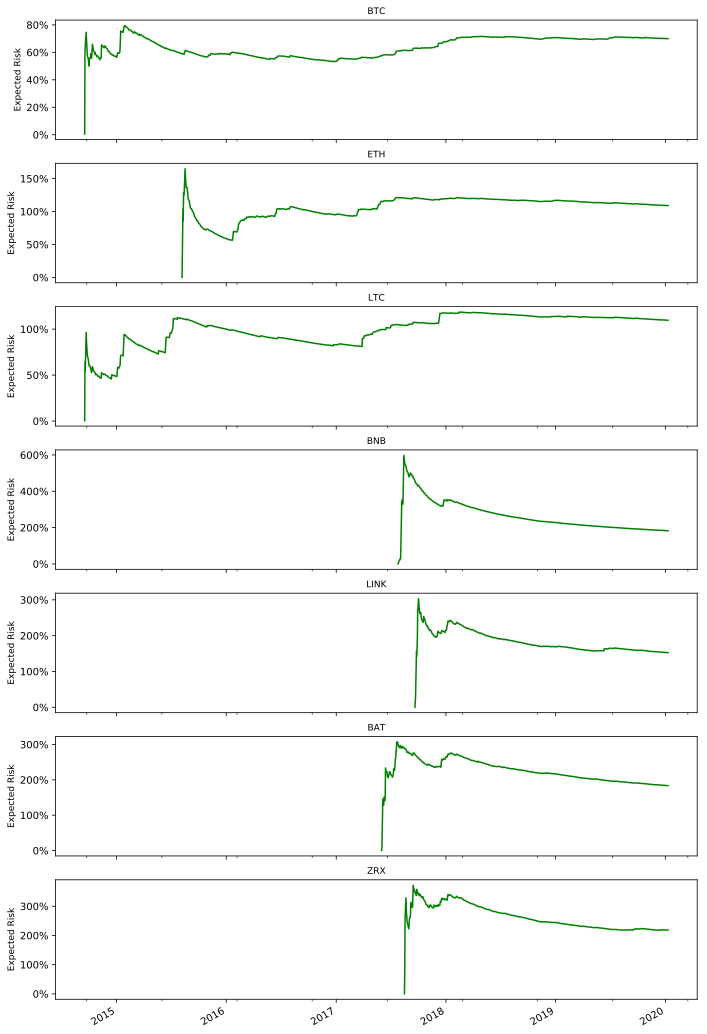

In [61]:
risk_list = []

fig, ax = plt.subplots(7, 1, sharex=True, figsize=[11.5, 20])

for i in range(0, 7):
    risk_list.append(performance_list[i].algo_volatility * 100)
    risk_list[i].plot(ax=ax[i], color='g')
    ax[i].yaxis.set_major_formatter(mtick.PercentFormatter())
    ax[i].set_ylabel('Expected Risk', fontsize = 9)
    ax[i].set_title(asset_list[i], fontsize = 9)

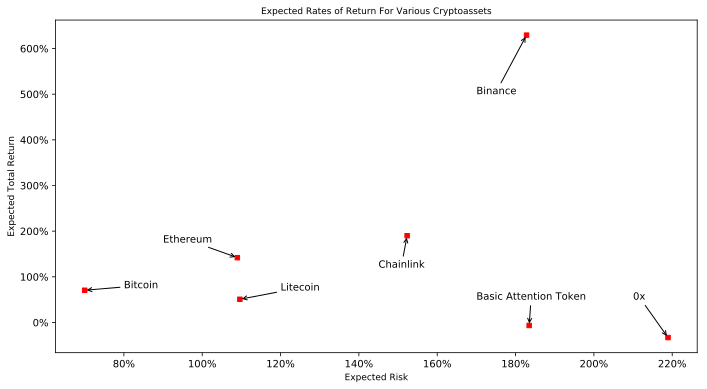

In [78]:
# plot frontier, max sharpe & min Volatility values with a scatterplot
ax = df.plot.scatter(x='Volatility', y='Returns', marker = 's', color='r', edgecolors='r', figsize=(11.5, 6))
plt.xlabel('Expected Risk', fontsize = 9)
plt.ylabel('Expected Total Return', fontsize = 9)
plt.title('Expected Rates of Return For Various Cryptoassets', fontsize = 9)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
#ax.set(xlim=(50, 250), ylim=(-50, 300))

#https://matplotlib.org/3.1.1/tutorials/text/annotations.html

plt.annotate('Bitcoin', xy=(df.iloc[0]['Volatility'], df.iloc[0]['Returns']), xytext=(80, 75),
             arrowprops=dict(arrowstyle="->"))

plt.annotate('Ethereum', xy=(df.iloc[1]['Volatility'], df.iloc[1]['Returns']), xytext=(90, 175),
             arrowprops=dict(arrowstyle="->"))

plt.annotate('Litecoin', xy=(df.iloc[2]['Volatility'], df.iloc[2]['Returns']), xytext=(120, 70),
             arrowprops=dict(arrowstyle="->"))

plt.annotate('Binance', xy=(df.iloc[3]['Volatility'], df.iloc[3]['Returns']), xytext=(170, 500),
             arrowprops=dict(arrowstyle="->"))

plt.annotate('Chainlink', xy=(df.iloc[4]['Volatility'], df.iloc[4]['Returns']), xytext=(145, 120),
             arrowprops=dict(arrowstyle="->"))

plt.annotate('Basic Attention Token', xy=(df.iloc[5]['Volatility'], df.iloc[5]['Returns']), xytext=(170, 50),
             arrowprops=dict(arrowstyle="->"))

plt.annotate('0x', xy=(df.iloc[6]['Volatility'], df.iloc[6]['Returns']), xytext=(210, 50),
             arrowprops=dict(arrowstyle="->"))

plt.show()